# 02. Neural Network Classification with PyTorch

Classification is a problm of predicting whether something is one thing or another. (there can be multiple things as the options)

Course Materials: https://www.learnpytorch.io/02_pytorch_classification/

Course Github: https://github.com/mrdbourke/pytorch-deep-learning

Extra Reading Materials:

Neural Networks: https://madewithml.com/courses/foundations/neural-networks/

## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles. X is typically matrix features. In this case y is
# serving as the label for each X.
# make_circles is often used for evaluating the performance of
# machine learning algorithms.
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42) # similar to making a random seed

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X (sample):\n {X[:5]}")
print(f"First 5 samples of y (label):\n {y[:5]}")

First 5 samples of X (sample):
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y (label):
 [1 1 1 1 0]


In [ ]:
# Make a DataFram of circle data using Pandas
# Use Pandas to break the columns from each row of X into separate
# pandas datafram columns. The ':' means "for all rows of X" in this case.
# so, for all rows of X, take the first element and assign it to X1
# and the 2nd element and assign it to X2. In addition, assign y to the
# "label" column.
# Now we have our data in a nice table for further visualization
# and processing.
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


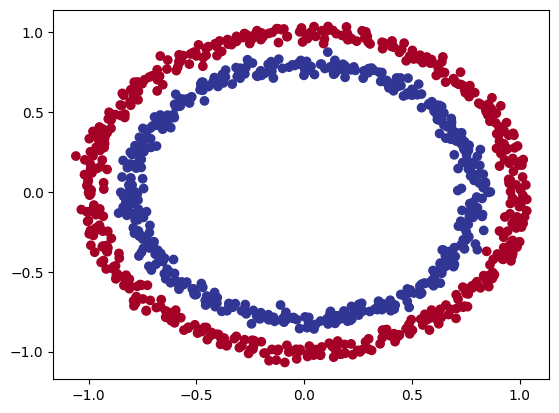

In [ ]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

Google: Toy Datasets scikit learn

Q1: What might the input and output shape of this data look like?

Q2: How might we split this data into training and test?

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape
# 2 to 1. Two features to one label.

((1000, 2), (1000,))

In [ ]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [ ]:
# View the first example of features and labels.
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")
# y is a scalar, a single value, so it doesn't return a shape
# for our purposes, it can be treated as a shape of 1.


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn our data into tensors and create train and test splits.

In [ ]:
import torch
torch.__version__

'2.8.0+cu126'

In [ ]:
type(X), X.dtype
# the default type of numpy arrays is float64
# the default type for pytorch is float32

(numpy.ndarray, dtype('float64'))

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
type(X), X.dtype, type(y), y.dtype
# Now we have both of our features in the same data type
# so that we can use them as tensors with pytorch
# and avoid type errors later on.

(torch.Tensor, torch.float32, torch.Tensor, torch.float32)

In [ ]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# Split the data into training and test sets
# Let's try a random split using scikit learn.
# Because we are using scikit learn, torch.manual_seed(42)
# won't affect train_test_split, so we set
# random_state to set the seed number.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #20% of the data will be test
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
n_samples
# since we defined n_samples at the beginning, we could adjust
# this number to try training on different sample sizes.

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on CPU or GPU.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop.

In [ ]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device is: {device}")
# Now we have access to the device string in device
# and we can reference that for the rest of our script
# for moving data to the right portion of computer memory, cpu or gpu memory.

Current device is: cpu


In [ ]:
X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

Now we've set up device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create two `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Define a `forward()` method that outlines the forward pass (forward computation) of the model.
4. Instantiate an instance of our model class and send it to the target device.

In [ ]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create two linear layers capable of handling the shapes of our data.
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in two features and upscales to 5 features.
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in five features from previous later and outputs a single features (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  # recursive notation.
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# 4. Instantiate an instance of our model class and send it to the target device.
model_0 = CircleModelV1().to(device)

In [ ]:
model_0, device, next(model_0.parameters()).device
# Get some info about what device our model and params are running on
# for diagnostic purposes.

(CircleModelV1(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 'cpu',
 device(type='cpu'))

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5314, -0.1852],
                      [-0.3285, -0.6294],
                      [ 0.1188, -0.4342],
                      [-0.2463,  0.4014],
                      [-0.3495,  0.6973]])),
             ('0.bias', tensor([ 0.1841, -0.3582,  0.5946,  0.7007, -0.2222])),
             ('1.weight',
              tensor([[ 0.4069, -0.2767,  0.2687,  0.0311, -0.0310]])),
             ('1.bias', tensor([-0.0165]))])

In [ ]:
# Make predictions. Make sure that X_test is moved to the
# device the model is running on.
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.1992],
        [0.3253],
        [0.1140],
        [0.2223],
        [0.5038],
        [0.5777],
        [0.6240],
        [0.6842],
        [0.0977],
        [0.3381]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use in this case?

Again... this is problem specific.

For example, for regression you might want MAE or MSE (Mean Squared Error)

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorcy has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - understanding-binary-cross-entropy-log-loss-a-visual-explanation

In [ ]:
# Setup the loss function
# loss_fn = nn.BCELoss() # Requires the input to have gone into the sigmoid activation function before use.
loss_fn = nn.BCEWithLogitsLoss() # Has the sigmoid activation function built-in. Provides additional numeric stability.

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  #print(f"correct: {correct}")
  acc = (correct / len(y_pred)) * 100
  return acc


## 3. Train model

Run the model through a training loop with the following steps.

1. Forward pass
2. Calculate the loss
3. Optimize zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary crossentropy and softmax for classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`.

In [ ]:
# View the first 5 outputs of the forward pass on the test data.
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
print(y_logits)

tensor([[0.1992],
        [0.3253],
        [0.1140],
        [0.2223],
        [0.5038]])


In [ ]:
# Use the sigmoid activation function on our model logits to
# turn them into prediction probabilities.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5496],
        [0.5806],
        [0.5285],
        [0.5553],
        [0.6233]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
#Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
model_0.eval()
with torch.inference_mode():
  y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of the extra dimension with .squeeze()
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### 3.2 Building a training and testing loop

In [ ]:
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)
else:
  torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to the target device.
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()
  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate test loss / acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71326, Acc: 50.88% | Test loss: 0.71482, Test acc: 52.50%
Epoch: 10 | Loss: 0.70159, Acc: 53.25% | Test loss: 0.70452, Test acc: 51.50%
Epoch: 20 | Loss: 0.69764, Acc: 52.12% | Test loss: 0.70105, Test acc: 50.50%
Epoch: 30 | Loss: 0.69609, Acc: 51.12% | Test loss: 0.69971, Test acc: 51.00%
Epoch: 40 | Loss: 0.69536, Acc: 51.00% | Test loss: 0.69907, Test acc: 49.00%
Epoch: 50 | Loss: 0.69493, Acc: 50.88% | Test loss: 0.69870, Test acc: 48.00%
Epoch: 60 | Loss: 0.69463, Acc: 51.00% | Test loss: 0.69844, Test acc: 49.00%
Epoch: 70 | Loss: 0.69440, Acc: 50.62% | Test loss: 0.69822, Test acc: 48.50%
Epoch: 80 | Loss: 0.69422, Acc: 50.25% | Test loss: 0.69804, Test acc: 50.00%
Epoch: 90 | Loss: 0.69407, Acc: 50.00% | Test loss: 0.69787, Test acc: 49.50%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't
learning anything so to inspect it, let's make some predictions
and make them visiual!

In other words, "Visualize, visualize, visualize!"

In [ ]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


Download helper_functions.py


In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

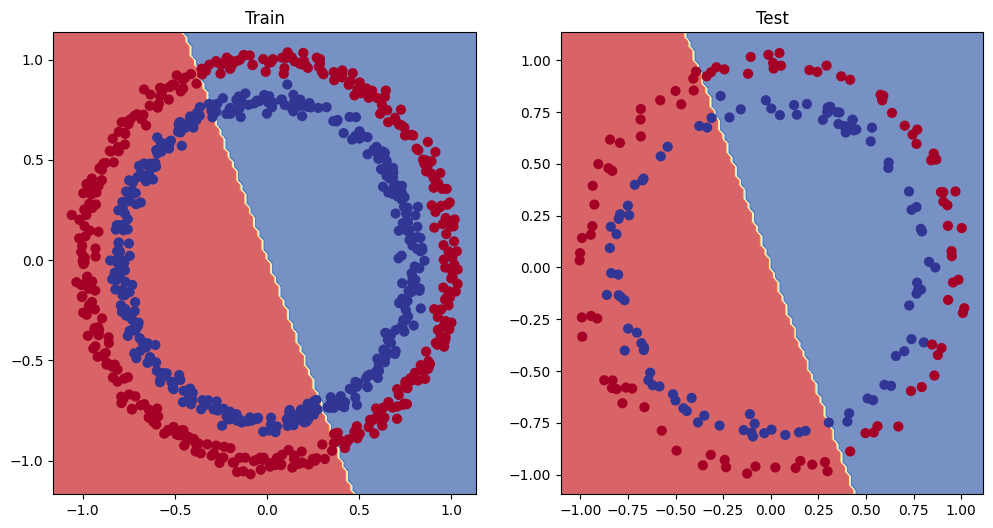

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2) # rows, columns, index
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data.
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to as hyperparameters.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [ ]:
# With this data set, we are focused on 2 in features and 1 out feature.
# Let's improve on our previous model!
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x))) # Leverage any behind the scenes optimization we can get by running it all in one go.

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn2 = nn.BCEWithLogitsLoss()
# Create an optimizer.
#    Remember:
#    Parameters are the internal variables of the machine learning model.
#    Features are the input variables from the data set we are working on.
optimizer2 = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)
# Write a training and evaluation loop for model_1
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)
else:
  torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data to the target device.
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model_2.train()
  # 1. Forward pass
  y_logits = model_2(X_train).squeeze() # Squeeze removes extra needed demensionality (extra brackets that may be on the outside of the list / tensor)
  y_pred = torch.round(torch.sigmoid(y_logits)) # Sigmoid activator function. turn logits -> pred probs -> pred labels

  # 2. Calculate loss and accuracy (accuracy is optional. just for diagnostics)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate test loss / acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 200 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 300 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 400 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 500 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 600 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 700 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 800 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 900 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%


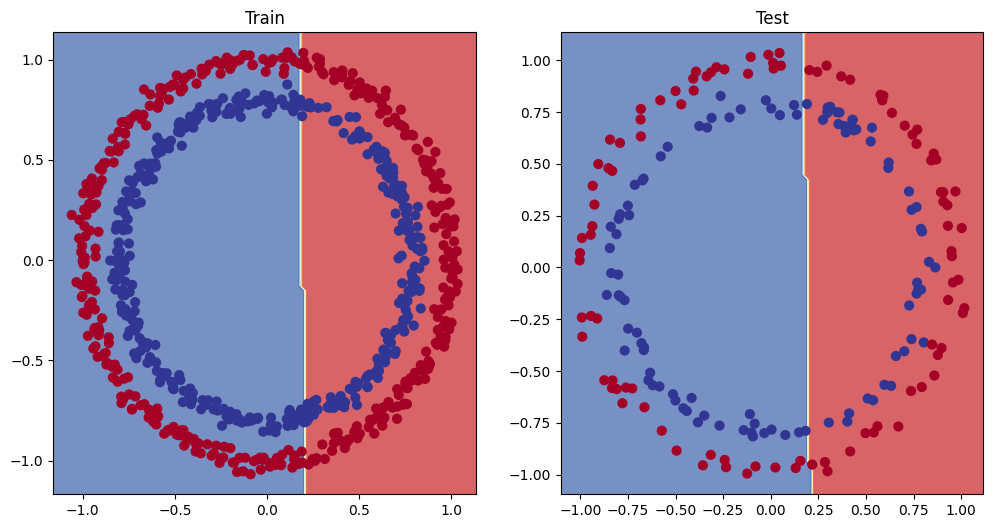

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem on the same model and see if it can solve it.

We know that our model on sheet 01 worked. That model was tested on linear data. Let's try that data on this model and see if it can solve it.

Let's see if our current model can learn anything at all. Let's test it on linear data and see if it passes that test.

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)


(80, 80, 20, 20)

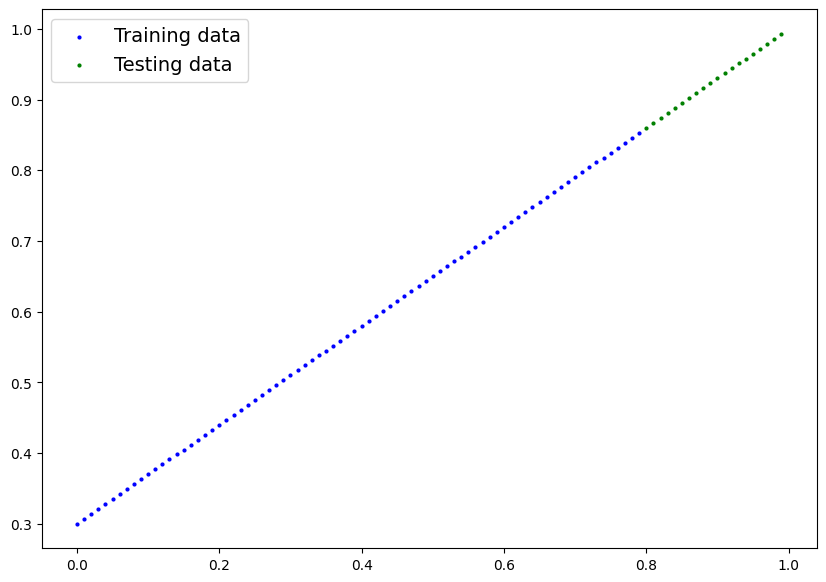

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
model_3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.001)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)


for epoch in range(epochs):
  model_3.train()
  y_pred = model_3(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_pred = model_3(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.7598584890365601 | Test loss: 0.94965
Epoch: 100 | Loss: 0.4027175009250641 | Test loss: 0.54029
Epoch: 200 | Loss: 0.05876145511865616 | Test loss: 0.13480
Epoch: 300 | Loss: 0.014611683785915375 | Test loss: 0.03342
Epoch: 400 | Loss: 0.003082635346800089 | Test loss: 0.00008
Epoch: 500 | Loss: 0.0030881264247000217 | Test loss: 0.00012
Epoch: 600 | Loss: 0.0030934172682464123 | Test loss: 0.00018
Epoch: 700 | Loss: 0.0029882495291531086 | Test loss: 0.00011
Epoch: 800 | Loss: 0.0029936223290860653 | Test loss: 0.00016
Epoch: 900 | Loss: 0.0028887882363051176 | Test loss: 0.00011


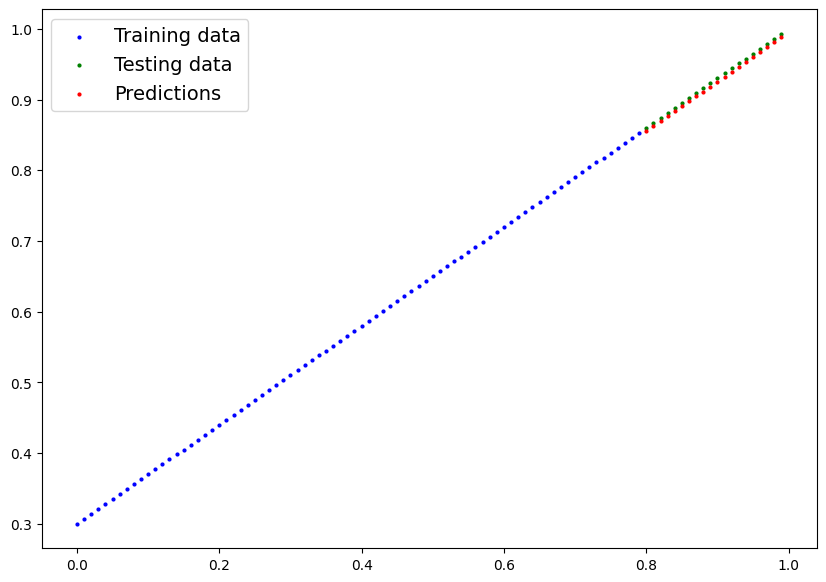

In [ ]:
model_3.eval()

with torch.inference_mode():
  y_preds = model_3(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds)

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

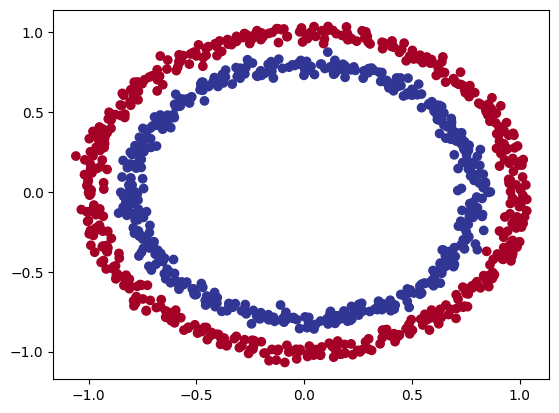

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
### 6.2 Building a model with non-linearity
from torch import nn
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_4 = CircleModelV3().to(device)

### 6.3 Training a model with non-linearity

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), # SGD - Random gradient descent
                            lr=0.1)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test loss: 0.6931881904602051, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test loss: 0.6910240054130554, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test loss: 0.6893961429595947, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test loss: 0.6872316598892212, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test loss: 0.684114933013916, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test loss: 0.6794120669364929, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test loss: 0.6728507280349731, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test loss: 0.6632164716720581, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test loss: 0.647568941116333, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test loss: 0.6214525699615479, Test Acc: 79.00%
Epoch: 1000 | Loss: 0.5682, Acc: 87.75% | Test loss: 0.5737816095352173, Test Acc: 86.50%
Epoch: 1100 | Loss: 0.48

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_4(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

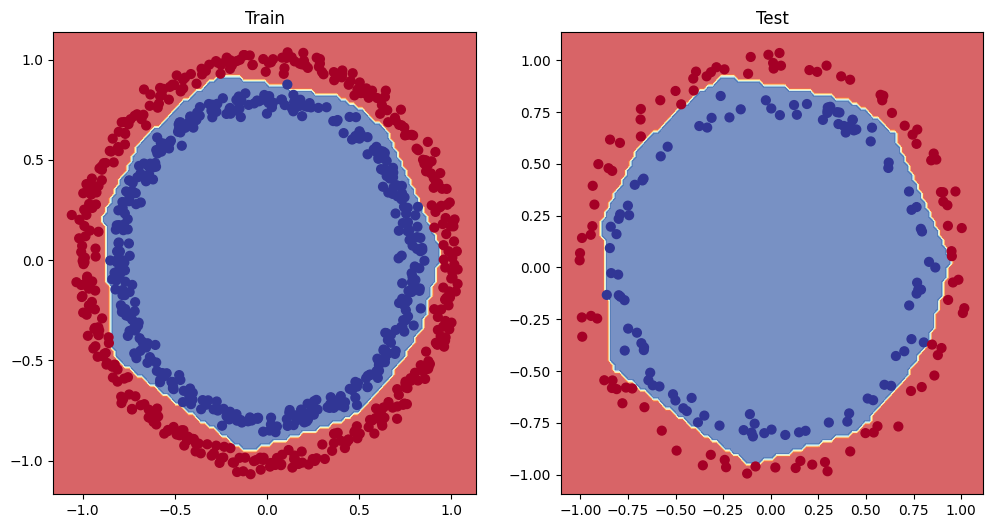

In [ ]:
# Set up our two column drawing space
plt.figure(figsize=(12, 6))
# Plot graph one in subplot one
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
# Plot graph two in subplot two
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

These tools are linear and non-linear functions.

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

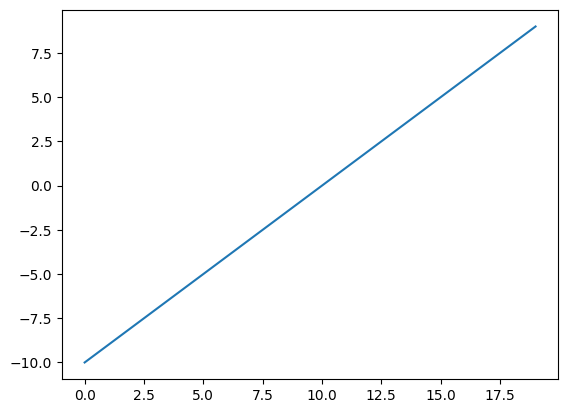

In [ ]:
# Visualize the tensor
plt.plot(A)

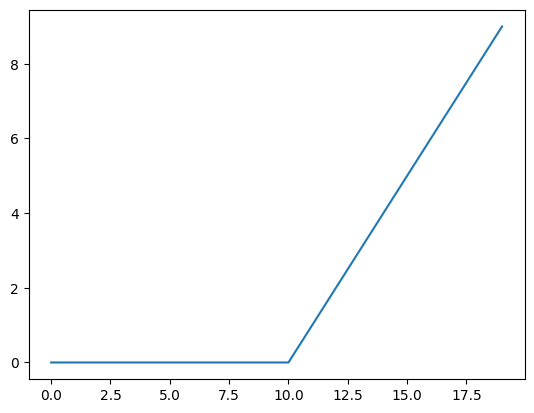

In [ ]:
plt.plot(torch.relu(A))

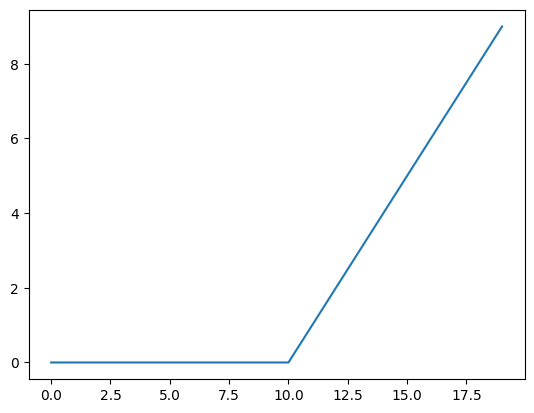

In [ ]:
## Let's write our own relu function. It's really easy.
## Check the relu documentation for more info.
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))

In [ ]:
# Now let's make the SIGMOID function
# 1 / 1 + pow(-x, 2)
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

In [ ]:
A, sigmoid(A)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
         1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
         8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
         9.9966e-01, 9.9988e-01]))

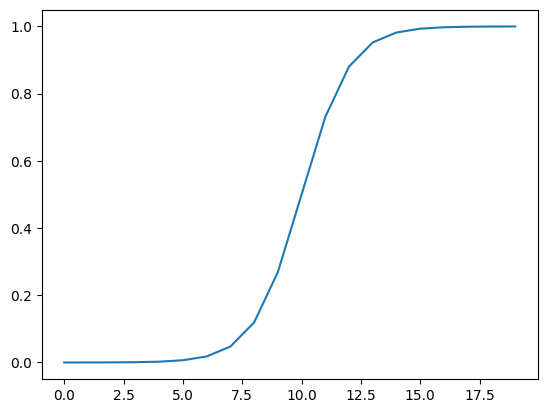

In [ ]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not faud)
* Multi-class classification = more than one thing

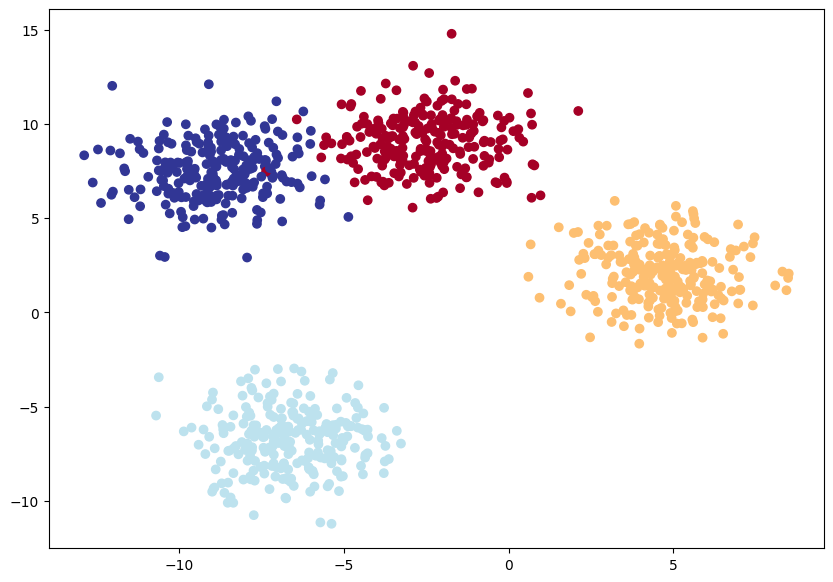

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split
import torch.nn as nn

# Set the hyperparameters. It's common to put hyperparameters in all caps.
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
N_SAMPLES = 1000

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=N_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give our data a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn our data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # our loss function needs the data in LongTensor format rather than float.
# X_blob[:5], y_blob[:5]

# 3. Split into train and test data sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data. Let's get visual, visual!
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Build a multi-clas classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.
    Args:
      input_features (int): Number of input features to the model.
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device.
blob_model_1 = BlobModel(input_features=2,
                         output_features=4,
                         hidden_units=8).to(device)

blob_model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
torch.unique(y_blob_train), X_blob_train.shape, y_blob_train[:5]

(tensor([0, 1, 2, 3]), torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [ ]:
### CrossEntropyLoss - This criterion computes the cross entropy
### loss between input and target.
loss_fn = nn.CrossEntropyLoss()
## update the model parameters to try and reduce the loss.
optimizer = torch.optim.SGD(params=blob_model_1.parameters(),
                            lr=0.01)



### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then prediction labels.

Logits (raw output of the model) -> Prediction Probabilities (use `torch.softmax`) -> Prediction labels (take the argmax of the prediction probabilities)

In [ ]:
#blob_model_1(X_blob_test.to(device))[:5]

blob_model_1.eval()
with torch.inference_mode():
  y_logits = blob_model_1(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [ ]:
y_prediction_probs = torch.softmax(y_logits, dim=1)

In [ ]:
torch.max(y_prediction_probs[1]), torch.argmax(y_prediction_probs[1])

(tensor(0.3336), tensor(0))

In [ ]:
# Convert our model's prediction probabilites to labels.
y_predictions = torch.argmax(y_prediction_probs, dim=1)
y_predictions

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set number of epochs
epochs = 100
#configure logging frequency
LOG_FREQUENCY = 20

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through the data
for epoch in range(epochs):
  blob_model_1.train()

  y_logits = blob_model_1(X_blob_train)
  y_predictions = torch.softmax(y_logits, dim=1).argmax(dim=1) # somewhat literally "soft max" as in: rescale the data elements to fit in a range from 0 to 1 and also sum to 1. Then use argmax to get the index of the highest value in the set. This essentially gets the category index as the return value, thus turning it into a prediction.

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,  # compare the actual categories to the predictions that came from the model to determine accuracy for this run.
                    y_pred=y_predictions)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  blob_model_1.eval()
  with torch.inference_mode():
    test_logits = blob_model_1(X_blob_test)
    test_predictions = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_predictions)

    # Print out what's happeningggggg
    if (epoch % LOG_FREQUENCY == 0) or (epoch + 1 == epochs):
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.1472, Test acc: 38.50%
Epoch: 20 | Loss: 0.9819, Acc: 62.62% | Test loss: 0.9976, Test acc: 57.50%
Epoch: 40 | Loss: 0.8529, Acc: 88.38% | Test loss: 0.8834, Test acc: 87.50%
Epoch: 60 | Loss: 0.7635, Acc: 93.62% | Test loss: 0.7998, Test acc: 94.50%
Epoch: 80 | Loss: 0.6977, Acc: 95.62% | Test loss: 0.7356, Test acc: 95.00%
Epoch: 99 | Loss: 0.6464, Acc: 96.75% | Test loss: 0.6838, Test acc: 97.00%


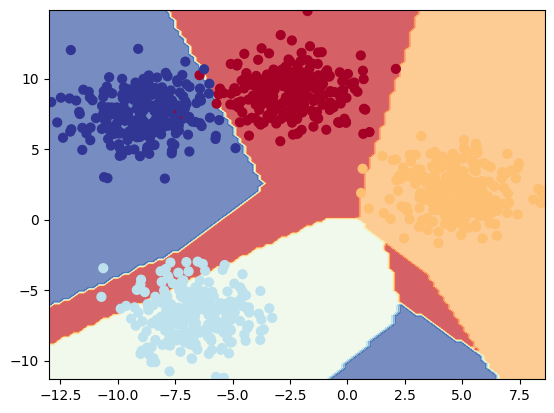

In [ ]:
plot_decision_boundary(blob_model_1, X_blob, y_blob)

In [ ]:
# Make predictions
blob_model_1.eval()
with torch.inference_mode():
  y_logits = blob_model_1(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.5520,  1.7702, -3.0464, -2.5323],
        [-0.1348, -2.3305, -2.3721,  0.0972],
        [ 0.1727, -0.2462,  0.3317, -0.0312],
        [-0.9623,  1.3257, -1.6128, -1.5732],
        [ 0.0045, -2.1045, -3.4698, -0.7000],
        [-0.2060, -2.6914, -2.7822,  0.1333],
        [ 0.0815, -0.3303,  0.2308, -0.0381],
        [ 0.0133, -2.3748, -2.8843, -0.2998],
        [ 0.1518, -0.3270,  0.2987, -0.0882],
        [ 0.0534, -2.3575, -2.9727, -0.3954]])

In [ ]:
y_prediction_probabilities = torch.softmax(y_logits, dim=1)

In [ ]:
y_predictions = torch.argmax(y_prediction_probabilities, dim=1)
y_predictions == y_blob_test

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, 

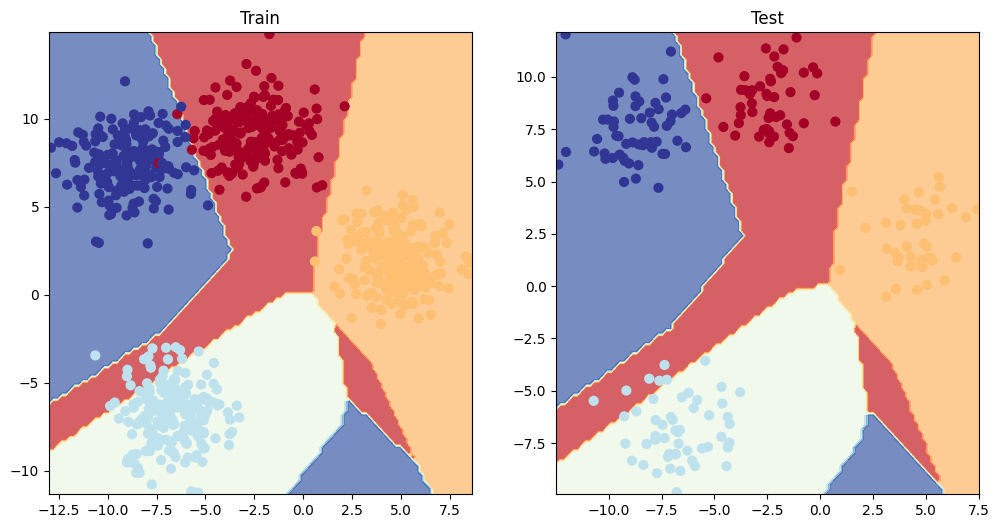

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model_1, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score - Combines precision and recall.
* Confusion matrix
* Classification report

Check torchmetrics for more eval functions.

To install torchmetrics in Google lab, Use: !pip install torchmetrics

make sure you move torchmetrics to your device with to(device).

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.8 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
torchmetric_accuracy(y_predictions, y_blob_test)

tensor(0.9700)

## Exercises and Extra Curricular Content

https://www.learnpytorch.io/02_pytorch_classification/#exercises